# LOS Prediction - Feature Selection

This notebook performs LOS prediction on the 24 or 48 hour dataset after keeping only columns identified by feature selection. 

LOS prediction here is done using both linear regression and feedforward DNN.

In [241]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

import numpy as np

print(tf.__version__)

2.0.0


(0, 200.0)

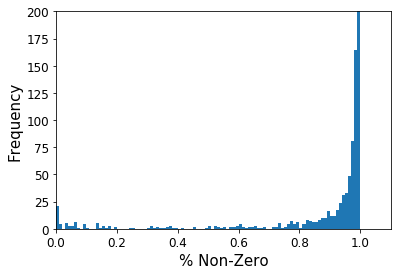

In [242]:

raw_dataset = pd.read_csv('../data/exp/pneumonia-t3/first48hours.csv', header=0)
df = raw_dataset.copy()

# Plot how many columns have non-zero values
(df==0).mean().hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("% Non-Zero", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,1.1])
plt.ylim([0,200.0])



In [243]:

print("Num columns starting: " + str(len(df.columns)))

df = df.loc[:, (df==0).mean() < .9]
df.fillna(0, inplace=True)
df = df.replace([np.inf, -np.inf], 0)

# Remove rows where the chartevents aren't available
df = df[df['Heart Rate'] > 0]

# Remove outliers
df = df[df['los'] <= 100]

# Shuffle data because data is ordered by admittime currently
df = df.sample(frac=1).reset_index(drop=True)
df.tail()


Num columns starting: 2474


,status,los,age,gender,insurance,language,religion,marital_status,ethnicity,Anion Gap,...,Systolic,Systolic-trend,O2 Flow.1,O2 Flow-trend.1,Respiratory Rate,Respiratory Rate-trend,Temperature.1,Temperature-trend.1,O2,O2-trend
3877,0,3.672,65.7564,M,Medicare,0,CATHOLIC,MARRIED,WHITE,11.667,...,105.484,0.886,34.333,-3.731,59.483,-0.020,37.074,0.005,0.000,0.000
3878,1,10.028,53.2113,F,Private,ENGL,BUDDHIST,SINGLE,WHITE,11.500,...,102.000,-4.373,0.000,0.000,21.393,0.586,0.000,0.000,93.607,0.002
3879,0,19.972,54.1504,M,Private,0,NOT SPECIFIED,MARRIED,UNKNOWN/NOT SPECIFIED,14.333,...,113.960,0.591,0.000,0.000,60.879,0.221,49.302,-0.465,0.000,0.000
3880,0,4.997,78.4329,M,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,16.000,...,115.000,0.379,1.542,0.029,22.630,-0.264,0.000,0.000,98.043,0.070
3881,0,11.803,86.2661,M,Medicare,ENGL,GREEK ORTHODOX,MARRIED,WHITE,11.333,...,119.833,-1.341,15.000,0.000,25.694,0.035,0.000,0.000,98.347,0.112


In [244]:
# One hot encode the demographic columns
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    df = df.join(one_hot)

df = df.loc[:, (df==0).mean() < .9]

In [245]:
los = df.pop('los')


In [246]:
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from math import sqrt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest


# NORMALIZE THE DATASET
stats = df.describe()
stats = stats.transpose()

def norm(x):
  return (x - stats['mean']) / stats['std']
normed_df = norm(df)

print("Num columns before feature selection: " + str(len(normed_df.columns)))

# RUN FEATURE SELECTION BASED ON SGD LINEAR REGRESSION
# clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.0001)
# sfm = SelectFromModel(clf, threshold=0.26) #0.19 = 72 features -> pretty good
# sfm.fit(normed_df, los)
# feature_idx = sfm.get_support()
# transformed_df = normed_df.loc[:,feature_idx]
# print("Num columns after feature selection: " + str(len(transformed_df.columns)))


# RUN FEATURE SELECTION BASED ON ELASTIC NET LINEAR REGRESSION
elastic = ElasticNet(l1_ratio=0.35, max_iter=10000)
elastic.fit(normed_df, los)
coef = pd.Series(elastic.coef_, index = normed_df.columns)
# features = coef.abs().sort_values(ascending=False).head(64).index
features = normed_df.columns[coef != 0]
transformed_df = normed_df[list(features)]
print(features)
print("Num columns after feature selection: " + str(len(transformed_df.columns)))


# RUN FEATURE SELECTION BASED ON MUTUAL INFORMATION
# vals = mutual_info_regression(normed_df, los)
# features = df.columns
# output = [a for a in zip(features, vals)]
# output.sort(key=lambda pair: pair[1], reverse=True)
# features_to_keep = []
# i = 0
# while i < 43:
#     features_to_keep.append(output[i][0])
#     i += 1
# transformed_df = normed_df[features_to_keep]
# print("Num columns after feature selection: " + str(len(transformed_df.columns)))



# PRINT THE WEIGHT VECTOR
#coef = sfm.estimator_.coef_
#print(coef)

# DIVIDE INTO TRAIN/TEST
transformed_df.insert(0, 'los', los)
train_dataset = transformed_df.sample(frac=0.7)
test_dataset = transformed_df.drop(train_dataset.index)
train_labels = train_dataset.pop('los')
test_labels = test_dataset.pop('los')


X_train, X_val, y_train, y_val = train_test_split(train_dataset, train_labels, test_size=0.70)

# normed_train_data

clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.0001)
# clf = LinearRegression(normalize=True)
clf.fit(X_train, y_train)

y_train_preds = clf.predict(X_train)
training_error = mean_absolute_error(y_train, y_train_preds)
print("Training (LOS): " + str(training_error))

y_val_preds = clf.predict(X_val)
training_error = mean_absolute_error(y_val, y_val_preds)
print("Validation (LOS): " + str(training_error))

y_test_preds = clf.predict(test_dataset)
test_error = mean_absolute_error(test_labels, y_test_preds)
print("Testing (LOS): " + str(test_error))


Num columns before feature selection: 236
Index(['status', 'age', 'Bands-trend', 'MCHC-trend', 'MCV-trend',
       'Neutrophils', 'RDW-trend', 'Red Blood Cells', 'pH', 'pO2',
       'Creatinine, Urine', 'Osmolality, Urine', 'Oxygen Saturation',
       'Temperature', 'PEEP', 'Tidal Volume', 'Lipase', 'Troponin T-trend',
       'Free Calcium', 'Sodium, Whole Blood', 'Hematocrit, Calculated',
       'Chloride, Whole Blood', 'Vancomycin', 'Fibrinogen, Functional',
       'Amylase', 'FENT2I', 'CHLO15L', 'PRED20', 'CEFX1F', 'KCL20PM',
       'SENN187', 'MIDA50I', 'ALBU3H', 'IPRA2H', 'NS250', 'PROP100IG',
       'PNEU25I', 'PANT40I', 'LEV250', 'LORA2I', 'LR1000', 'SW50', 'KCLBASE2',
       'INSULIN', 'MAGS1I', 'ZITHR250', 'NS100', 'VIAL', 'D5W250', 'D5W100',
       'CALG1I', 'Systolic', 'O2 Flow.1', 'O2 Flow-trend.1', 'Temperature.1',
       'O2', 'insurance_Medicare', 'language_0', 'language_ENGL'],
      dtype='object')
Num columns after feature selection: 59
Training (LOS): 5.1644521668051

In [247]:
# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

def build_model(i):
  model = keras.Sequential([
    layers.Dense(i, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(i, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5, name='dropout_2'),
    layers.Dense(i, activation='relu', input_shape=[len(train_dataset.keys())]),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
#     layers.Dropout(0.5, name='dropout_1'),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
#     layers.Dropout(0.5, name='dropout_2'),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


................................................................................

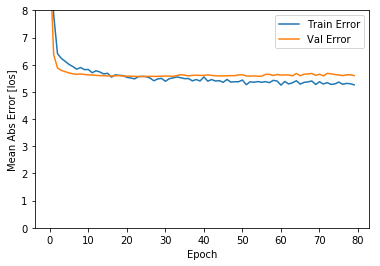

Train (LOS): 5.440962832314628
Validation (LOS): 5.606745181764875
Testing (LOS): 5.575648608378791


In [252]:

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 80

# for i in range(40):
#     model = build_model(20 + i)
#     history = model.fit(
#       train_dataset, train_labels,
#       epochs=EPOCHS, validation_split = 0.3, verbose=0,
#       callbacks=[PrintDot()])
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch
#     hist.tail()
#     print("Units = " + str(i) + ": " + str(hist["val_mae"][10:].mean()))
#     i += 1

model = build_model(26)
history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.3, verbose=0,
  callbacks=[PrintDot()])

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,8])
  plt.legend()
  plt.show()


plot_history(history)


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


print("Train (LOS): " + str(hist["mae"][10:].mean()))
print("Validation (LOS): " + str(hist["val_mae"][10:].mean()))

actual_predictions = model.predict(test_dataset)
test_error = mean_absolute_error(test_labels, actual_predictions)
print("Testing (LOS): " + str(test_error))



In [233]:

model = build_model(12)
history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.3, verbose=0,
  callbacks=[PrintDot()])



................................................................................

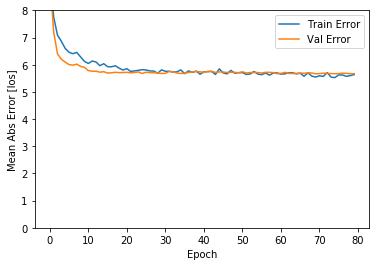

Train (LOS): 5.8010718296100565
Validation (LOS): 5.736488367055918
Testing (LOS): 5.526778734038521


In [234]:

plot_history(history)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


print("Train (LOS): " + str(hist["mae"][3:].mean()))
print("Validation (LOS): " + str(hist["val_mae"][3:].mean()))

actual_predictions = model.predict(test_dataset)
test_error = mean_absolute_error(test_labels, actual_predictions)
print("Testing (LOS): " + str(test_error))


## LOS Prediction based on different demographics

Using the features we've selected, can we achieve better performance with different subpopulations?

### 1) Based on outcomes (alive vs expiry)

Alive rows = 607
Dead rows = 607
STATUS = ALIVE

............................................................

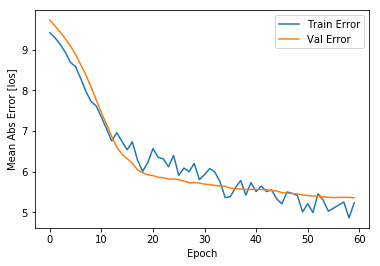

Train (LOS): 5.821552600860596
Validation (LOS): 5.7575111579895015
Testing (LOS): 5.757122339625935


In [264]:
alive_df = transformed_df[df["status"] == 0].head(607)
dead_df = transformed_df[df["status"] == 1]
print("Alive rows = " + str(len(alive_df)))
print("Dead rows = " + str(len(dead_df)))

train_dataset_dem = alive_df.sample(frac=0.7,random_state=0)
test_dataset_dem = alive_df.drop(train_dataset_dem.index)
train_labels_dem = train_dataset_dem.pop('los')
test_labels_dem = test_dataset_dem.pop('los')

X_train, X_val, y_train, y_val = train_test_split(train_dataset_dem, train_labels_dem, test_size=0.70)

print("STATUS = ALIVE")

model = build_model(8)

EPOCHS = 60

history = model.fit(
  train_dataset_dem, train_labels_dem,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,8])
  plt.legend()
  plt.show()


plot_history(history)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
print("Train (LOS): " + str(hist["mae"][10:].mean()))
print("Validation (LOS): " + str(hist["val_mae"][10:].mean()))

actual_predictions = model.predict(test_dataset_dem)
test_error = mean_absolute_error(test_labels_dem, actual_predictions)
print("Testing (LOS): " + str(test_error))



STATUS = DEAD
Dead rows = 607

............................................................

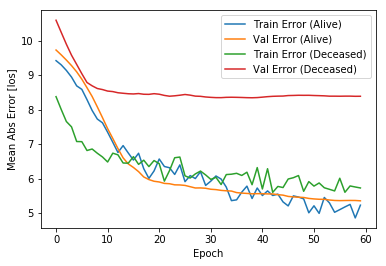

Train (LOS): 6.091581115722656
Validation (LOS): 8.402371063232422
Testing (LOS): 6.375010633730626


In [275]:

print("STATUS = DEAD")
dead_df = transformed_df[df["status"] == 1]
print("Dead rows = " + str(len(dead_df)))

train_dataset_dem = dead_df.sample(frac=0.7,random_state=0)
test_dataset_dem = dead_df.drop(train_dataset_dem.index)
train_labels_dem = train_dataset_dem.pop('los')
test_labels_dem = test_dataset_dem.pop('los')

X_train, X_val, y_train, y_val = train_test_split(train_dataset_dem, train_labels_dem, test_size=0.70)

def build_deceased_model(i):
  model = keras.Sequential([
    layers.Dense(i, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(i, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5, name='dropout_2'),
    layers.Dense(i, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_deceased_model(16)

EPOCHS = 60

history_dead = model.fit(
  train_dataset_dem, train_labels_dem,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

def plot_history(h1, h2):
  hist_alive = pd.DataFrame(h1.history)
  hist_alive['epoch'] = h1.epoch

  hist_dead = pd.DataFrame(h2.history)
  hist_dead['epoch'] = h2.epoch
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist_alive['epoch'], hist_alive['mae'],
           label='Train Error (Alive)')
  plt.plot(hist_alive['epoch'], hist_alive['val_mae'],
           label = 'Val Error (Alive)')
  plt.plot(hist_dead['epoch'], hist_dead['mae'],
           label='Train Error (Deceased)')
  plt.plot(hist_dead['epoch'], hist_dead['val_mae'],
           label = 'Val Error (Deceased)')
  plt.legend()
  plt.show()


plot_history(history, history_dead)

hist = pd.DataFrame(history_dead.history)
hist['epoch'] = history_dead.epoch
hist.tail()
print("Train (LOS): " + str(hist["mae"][10:].mean()))
print("Validation (LOS): " + str(hist["val_mae"][10:].mean()))

actual_predictions = model.predict(test_dataset_dem)
test_error = mean_absolute_error(test_labels_dem, actual_predictions)
print("Testing (LOS): " + str(test_error))






### 2) Based on payment method (medicare vs private)

Medicare rows = 2447
INSURANCE = Medicare

....................................................................................................

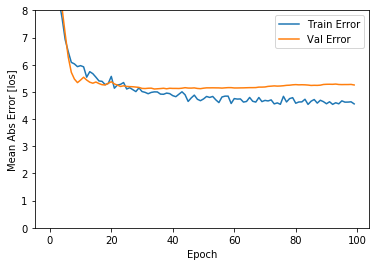

Train (LOS): 5.020745429796042
Validation (LOS): 5.317943838453784
Testing (LOS): 4.916439370220299


In [237]:
medicare_df = transformed_df[df["insurance_Medicare"] == 1]
print("Medicare rows = " + str(len(medicare_df)))

train_dataset = medicare_df.sample(frac=0.7,random_state=0)
test_dataset = medicare_df.drop(train_dataset.index)
train_labels = train_dataset.pop('los')
test_labels = test_dataset.pop('los')

X_train, X_val, y_train, y_val = train_test_split(train_dataset, train_labels, test_size=0.70)

print("INSURANCE = Medicare")

model = build_model(12)

EPOCHS = 100

history = model.fit(
  train_dataset.head(1000), train_labels.head(1000),
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,8])
  plt.legend()
  plt.show()


plot_history(history)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
print("Train (LOS): " + str(hist["mae"][3:].mean()))
print("Validation (LOS): " + str(hist["val_mae"][3:].mean()))

actual_predictions = model.predict(test_dataset)
test_error = mean_absolute_error(test_labels, actual_predictions)
print("Testing (LOS): " + str(test_error))





Private insurance rows = 1012
Insurance = PRIVATE

....................................................................................................

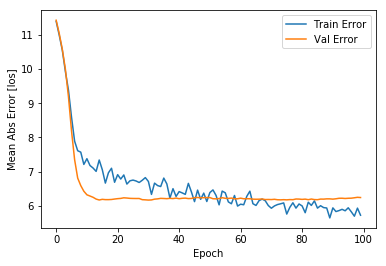

Train (LOS): 6.319561412599351
Validation (LOS): 6.2087416807810465
Testing (LOS): 6.263596875793055


In [238]:
private_df = transformed_df[df["insurance_Private"] == 1]
print("Private insurance rows = " + str(len(private_df)))

train_dataset = private_df.sample(frac=0.7,random_state=0)
test_dataset = private_df.drop(train_dataset.index)
train_labels = train_dataset.pop('los')
test_labels = test_dataset.pop('los')

X_train, X_val, y_train, y_val = train_test_split(train_dataset, train_labels, test_size=0.70)

print("Insurance = PRIVATE")

model = build_model(12)

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
print("Train (LOS): " + str(hist["mae"][10:].mean()))
print("Validation (LOS): " + str(hist["val_mae"][10:].mean()))

actual_predictions = model.predict(test_dataset)
test_error = mean_absolute_error(test_labels, actual_predictions)
print("Testing (LOS): " + str(test_error))





In [239]:
print(len(alive_df.values))
print(len(dead_df.values))
print(len(medicare_df.values))
print(len(private_df.values))

3275
607
2447
1012
